# Analyse synthesis outputs

In [1]:
%matplotlib notebook

import numpy as np
from matplotlib import pyplot as plt
import glob
from importlib import reload

import scatcovjax.Sphere_lib as sphlib
from scatcovjax.Scattering_lib import scat_cov_axi, scat_cov_dir
from s2wav.filter_factory.filters import filters_directional_vectorised

import s2fft
import s2wav
import scatcovjax.plotting as plot

plot.notebook_plot_format()


# Parameters

In [2]:
reality = True
sampling = 'mw'
multiresolution = True
L = 256
N = 2
epochs = 1000
J_min = 2

J_max = s2wav.utils.shapes.j_max(L)
J = J_max - J_min + 1
print(f'{J=} {J_max=}')

J=7 J_max=8


# Make filters

<IPython.core.display.Javascript object>


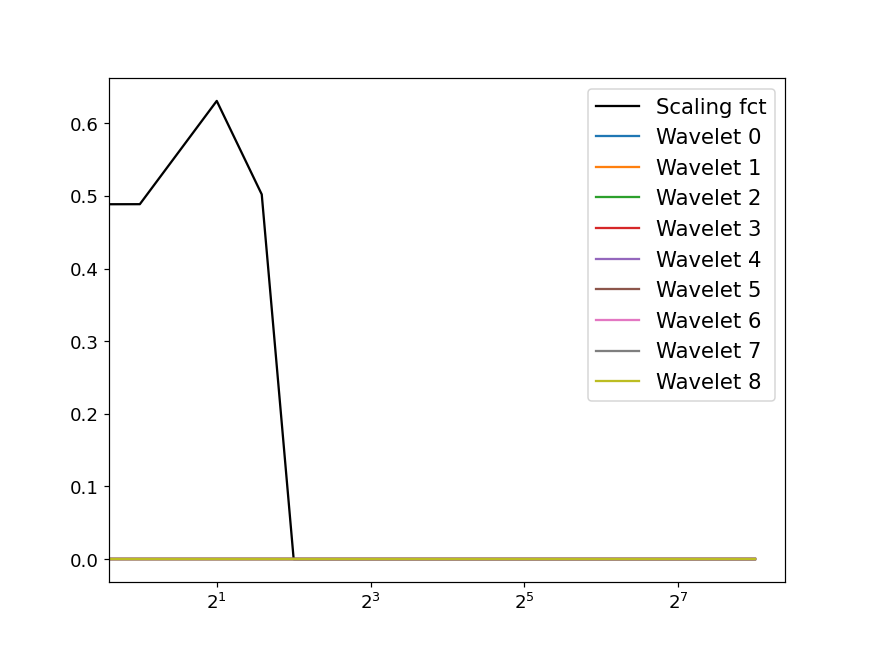

(<Figure size 800x600 with 1 Axes>, <Axes: >)

In [3]:
filters = filters_directional_vectorised(L, N, J_min)
plot.plot_filters(filters, real=True, m=L-1)

# Load the data

In [4]:
# List of job with these parameters
job = 7707
job_list = glob.glob(f'/travail/lmousset/scatJAX_tests_mai2023/*{job}*L{L}_N{N}_Jmin{J_min}_epochs{epochs}')
print(len(job_list), job_list)

# Choose the run
run = 0
output_dir = job_list[run]
print('\n', output_dir)

# flm
flm_target = np.load(output_dir + '/flm_target.npy')
flm_start = np.load(output_dir + '/flm_start.npy')
flm_end = np.load(output_dir + '/flm_end.npy')
print(flm_end.shape)

# Loss
loss_history = np.load(output_dir + '/loss.npy')

# Coeffs
tmean, tvar, tS1, tP00, tC01, tC11 = np.load(output_dir + '/coeffs_target.npy', allow_pickle=True)
smean, svar, sS1, sP00, sC01, sC11 = np.load(output_dir + '/coeffs_start.npy', allow_pickle=True)
emean, evar, eS1, eP00, eC01, eC11 = np.load(output_dir + '/coeffs_end.npy', allow_pickle=True)

1 ['/travail/lmousset/scatJAX_tests_mai2023/Job7707_L256_N2_Jmin2_epochs1000']

 /travail/lmousset/scatJAX_tests_mai2023/Job7707_L256_N2_Jmin2_epochs1000
(256, 256)


In [5]:
tP00

Array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1.], dtype=float64)

In [6]:
if reality:  # Get the full flm
    flm_target = sphlib.make_flm_full(flm_target, L)
    flm_start = sphlib.make_flm_full(flm_start, L)
    flm_end = sphlib.make_flm_full(flm_end, L)
print(flm_end.shape)

(256, 511)


In [7]:
### Cut the flm that are not contrained
flm_target = flm_target.at[0: 2**J_min + 1, :].set(0. + 0.j)

In [8]:
# Make the maps
f_target = s2fft.inverse_jax(flm_target, L, reality=reality)
f_start = s2fft.inverse_jax(flm_start, L, reality=reality)
f_end = s2fft.inverse_jax(flm_end, L, reality=reality)

# Plots

In [9]:
np.std(f_target)

Array(0.99791045, dtype=float64)

<IPython.core.display.Javascript object>


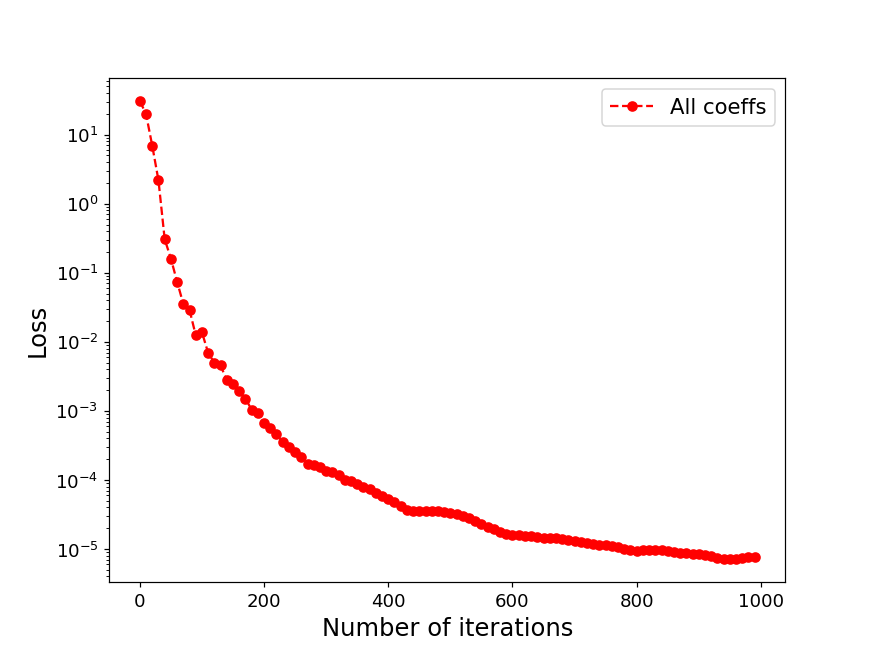

In [10]:
nit1 = 1000
nit2 = 1000
step = 10

plt.figure(figsize=(8, 6))
plt.plot(np.arange(0, nit1, step), loss_history[:int(nit1/step)], 'ro--', label='All coeffs')
#plt.plot(np.arange(nit1, nit1 + nit2, step), loss_history[int(nit1/step):], 'ro--', label='All coeffs')
#plt.plot(loss_history, 'bo--')
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Number of iterations')
plt.legend()

In [11]:
loss_history

array([3.08229023e+01, 1.98337217e+01, 6.90472446e+00, 2.18168011e+00,
       3.07190685e-01, 1.60271436e-01, 7.42170267e-02, 3.53564870e-02,
       2.89410540e-02, 1.24566094e-02, 1.37802541e-02, 6.90902399e-03,
       4.98833064e-03, 4.54655626e-03, 2.78247106e-03, 2.43236708e-03,
       1.93440921e-03, 1.50303767e-03, 1.04348082e-03, 9.20769616e-04,
       6.77446592e-04, 5.69136090e-04, 4.58416899e-04, 3.58479151e-04,
       2.95109573e-04, 2.49767654e-04, 2.14825142e-04, 1.68914707e-04,
       1.64990903e-04, 1.51734056e-04, 1.33473171e-04, 1.31793717e-04,
       1.16794943e-04, 1.01402350e-04, 9.56969693e-05, 8.77833381e-05,
       7.96585737e-05, 7.30677062e-05, 6.47531373e-05, 5.78308285e-05,
       5.22495201e-05, 4.75230385e-05, 4.16730682e-05, 3.68900736e-05,
       3.56071023e-05, 3.50676111e-05, 3.51646285e-05, 3.58883840e-05,
       3.56330245e-05, 3.47461368e-05, 3.37299997e-05, 3.22246698e-05,
       3.00746317e-05, 2.77442475e-05, 2.52904252e-05, 2.29785189e-05,
      

<IPython.core.display.Javascript object>


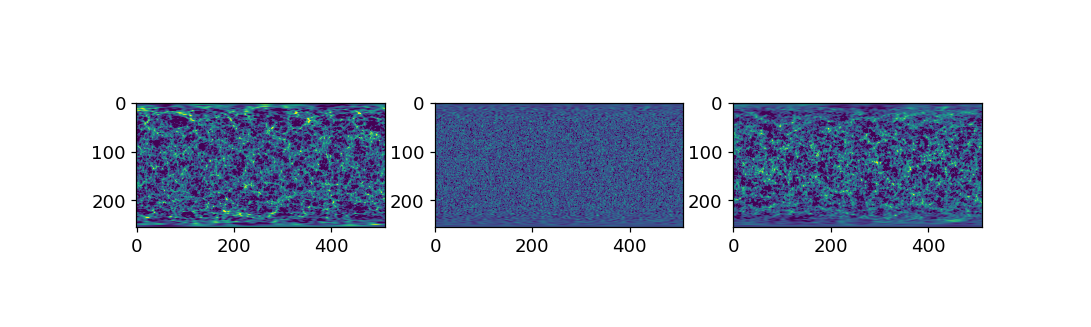

In [12]:
mn, mx = np.nanmin(f_target), np.nanmax(f_target)
mn, mx = -1, 3

fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(10,3))
ax1.imshow(f_target, vmax=mx, vmin=mn, cmap='viridis')
ax2.imshow(f_start, vmax=mx, vmin=mn, cmap='viridis')
ax3.imshow(f_end, vmax=mx, vmin=mn, cmap='viridis')
plt.show()

In [13]:
print(np.std(f_target), np.std(f_start))

0.997910452480947 0.7096516898787615


<IPython.core.display.Javascript object>


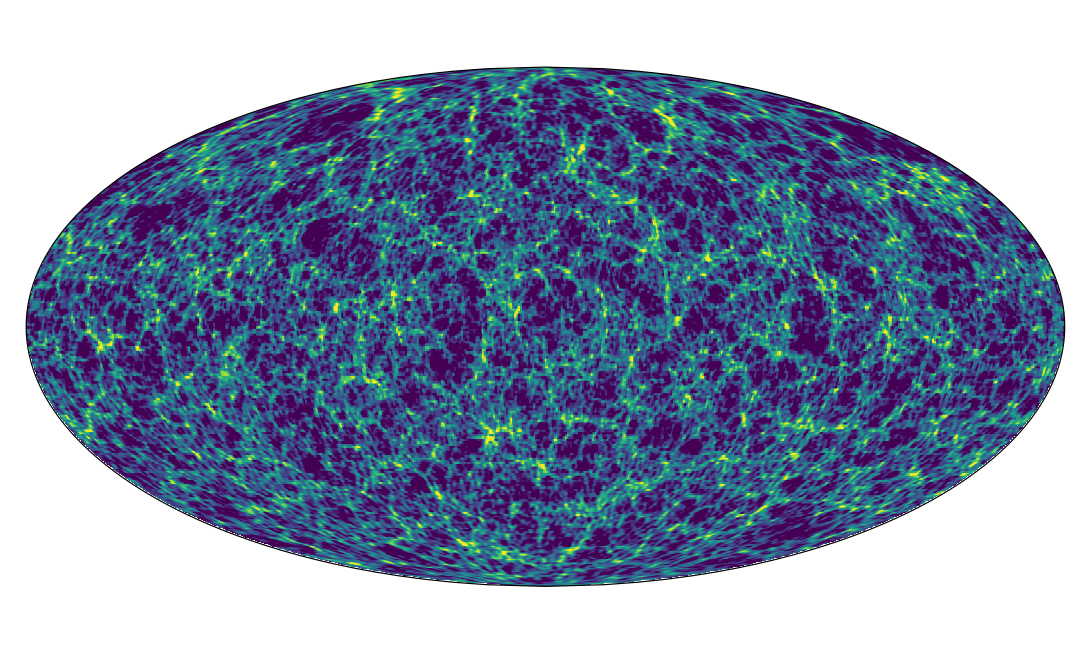

In [14]:
reload(plot)
plot.plot_map_MW_Mollweide(f_target, vmin=mn, vmax=mx, figsize=(10, 6), title='')#, title=f'Target - {mn=:.2f}, {mx=:.2f}')

<IPython.core.display.Javascript object>


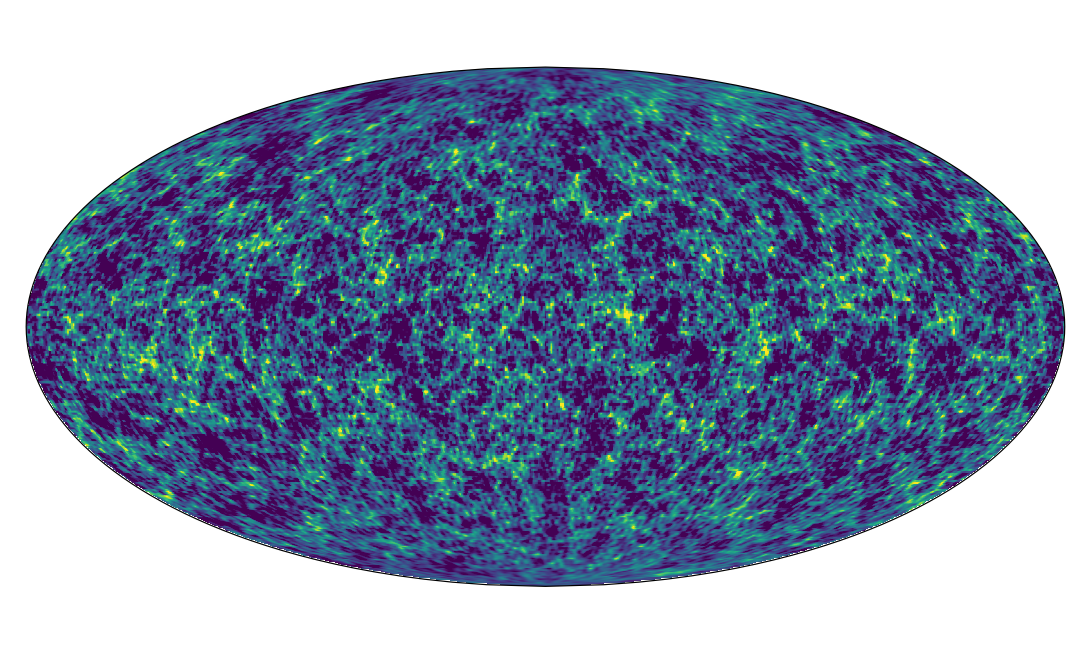

In [15]:
plot.plot_map_MW_Mollweide(f_end, vmin=mn, vmax=mx, figsize=(10, 6), title='')#, title=f'End - {mn=:.2f}, {mx=:.2f}')

<IPython.core.display.Javascript object>


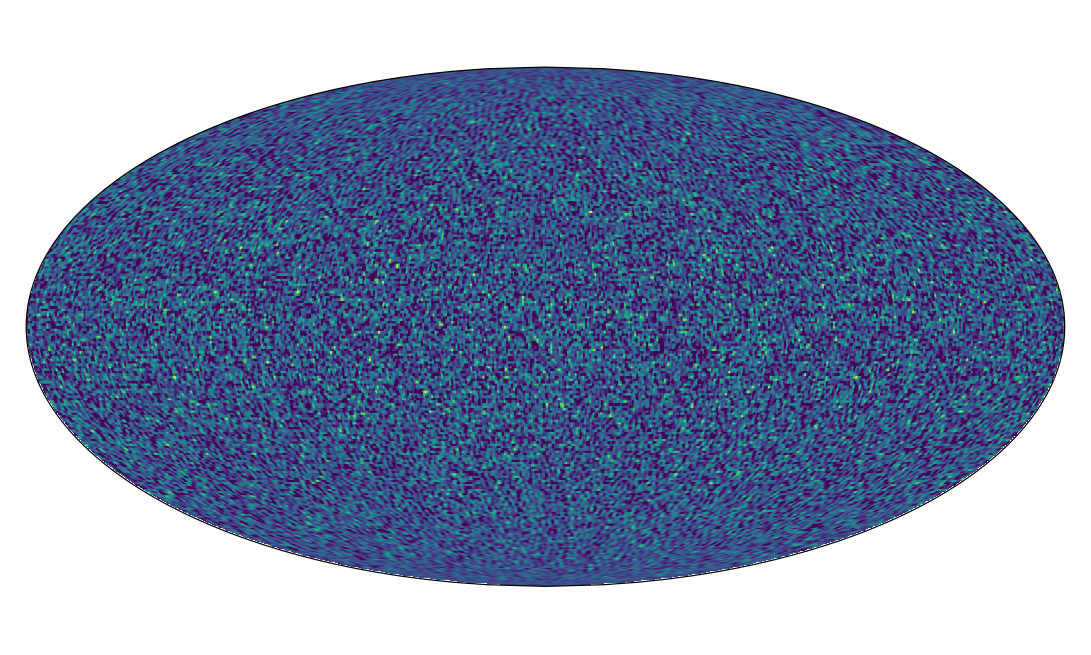

In [16]:
plot.plot_map_MW_Mollweide(f_start, vmin=mn, vmax=mx, title='', figsize=(10, 6))#title=f'Start - {mn=:.2f}, {mx=:.2f}')

In [17]:
np.sqrt(np.mean(np.abs(flm_start[1:]) ** 2))

0.007742070432287793

In [18]:
Ilm_square = flm_target * np.conj(flm_target)
# Compute the variance : Sum all except the (l=0, m=0) term
# Todo: TEST
# var = (np.sum(Ilm_square) - Ilm_square[0, L - 1]) / (4 * np.pi)
var = np.mean(Ilm_square - Ilm_square[0, L - 1])
print(var)

(9.529805952947321e-05+0j)


In [19]:
# plot.plot_sphere(f_end, L, sampling=sampling)

### Power spectrum

<IPython.core.display.Javascript object>


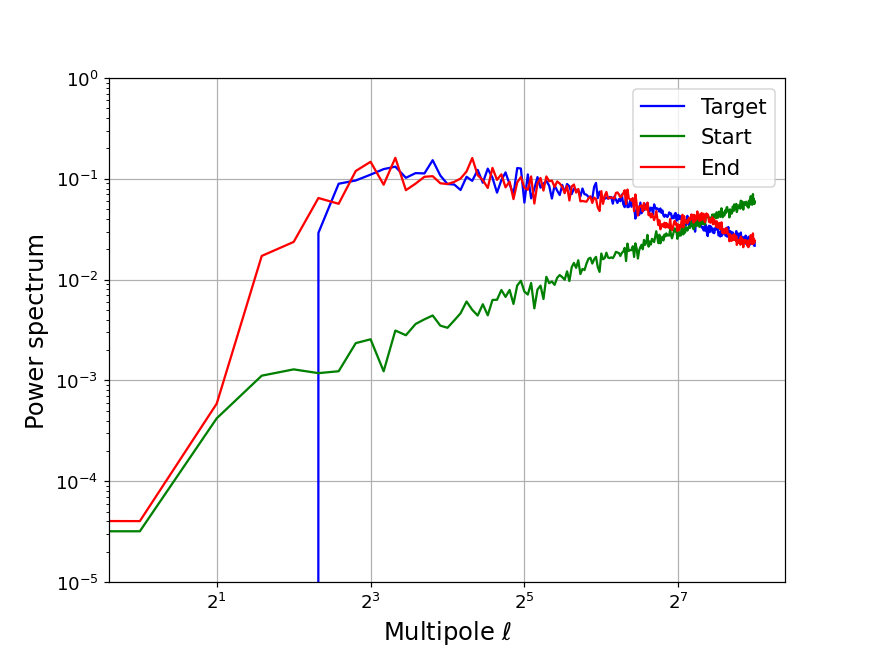

In [25]:
ps_target = sphlib.compute_ps(flm_target)
ps_start = sphlib.compute_ps(flm_start)
ps_end = sphlib.compute_ps(flm_end)

plt.figure(figsize=(8, 6))
plt.plot(ps_target, 'b', label="Target")
plt.plot(ps_start, 'g', label="Start")
plt.plot(ps_end, 'r', label="End")
plt.yscale("log")
plt.xscale("log", base=2)
plt.xlabel(r'Multipole $\ell$')
plt.ylabel('Power spectrum')
plt.grid()
#plt.xlim(2, 256)
plt.ylim(1e-5, 1)
plt.legend()

In [21]:
print('Mean:', tmean, smean, emean)
print('Var:', tvar, svar, evar)

Mean: 0.016352476981190633 0.002051320457021274 0.01689881202106873
Var: (0.9993258776990296+0j) (0.6215348034481296+0j) (0.9970778913551428+0j)


<IPython.core.display.Javascript object>


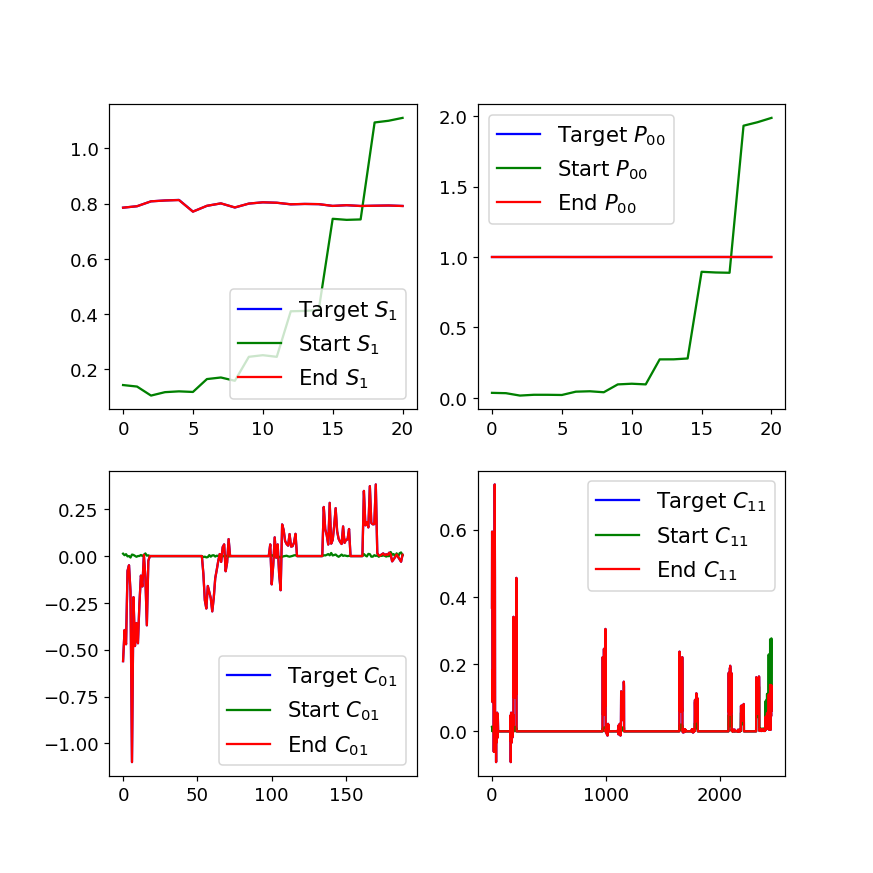

In [22]:
plot.plot_scatcov_coeffs(tS1, tP00, tC01, tC11, name='Target', hold=True, color='blue')

plot.plot_scatcov_coeffs(sS1, sP00, sC01, sC11, name='Start', hold=False, color='green')

plot.plot_scatcov_coeffs(eS1, eP00, eC01, eC11, name='End', hold=False, color='red')

<IPython.core.display.Javascript object>


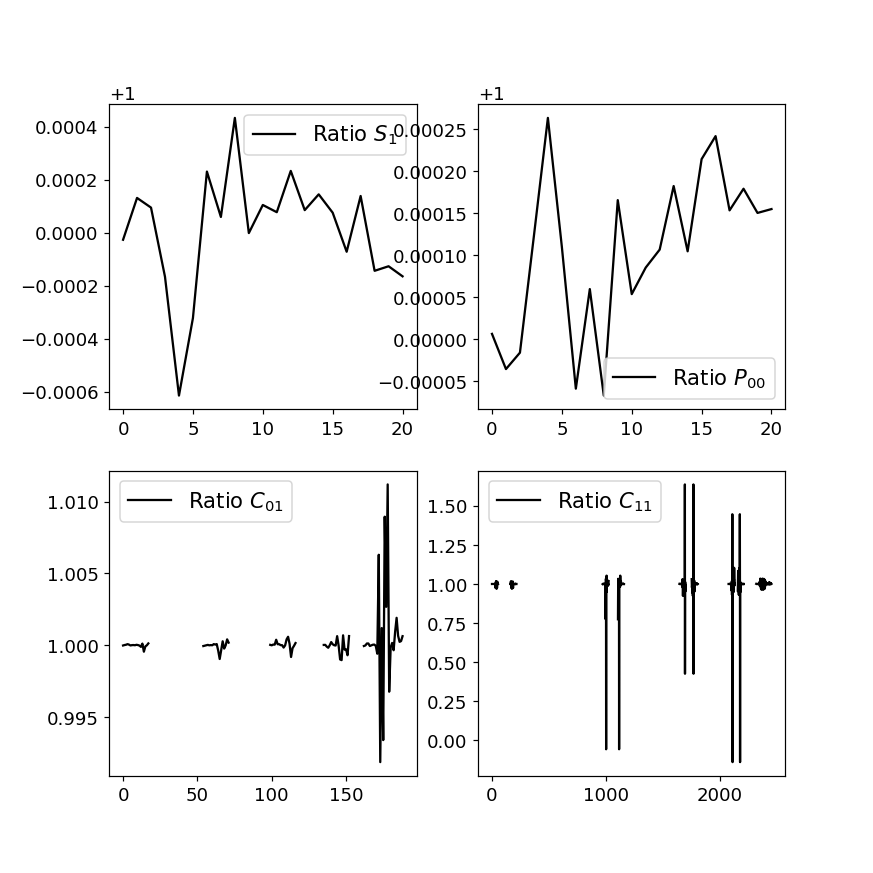

In [23]:
plot.plot_scatcov_coeffs(eS1/tS1, eP00/tP00, eC01/tC01, eC11/tC11, name='Ratio', hold=True, color='k')

<IPython.core.display.Javascript object>


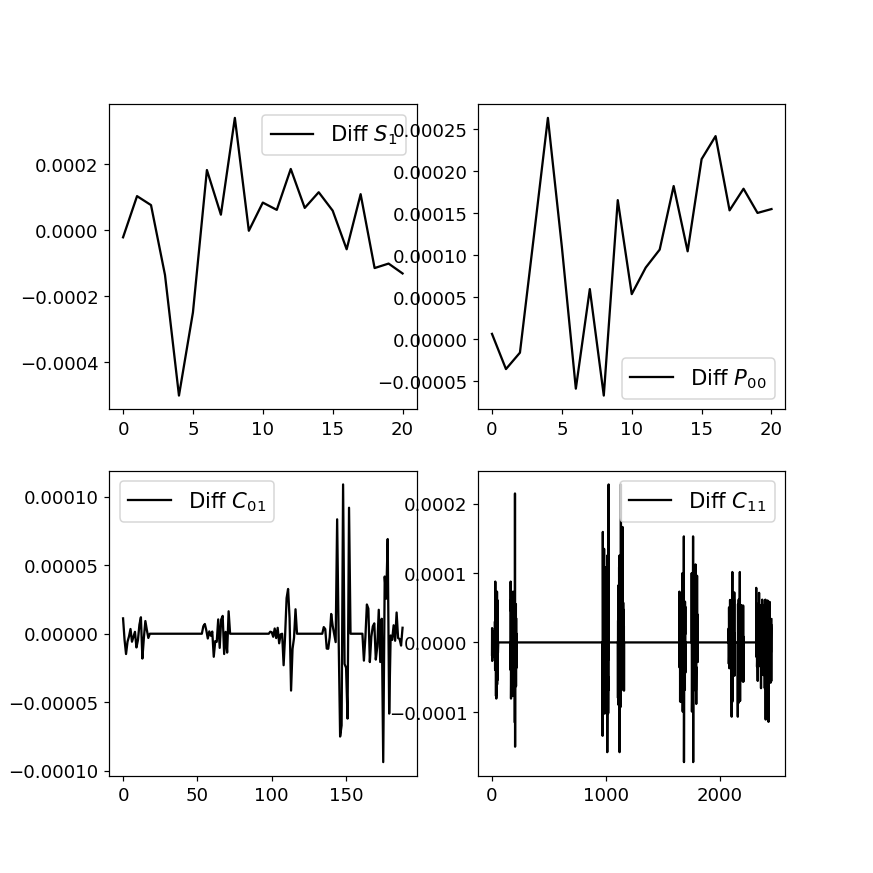

In [24]:
plot.plot_scatcov_coeffs(eS1-tS1, eP00-tP00, eC01-tC01, eC11-tC11, name='Diff', hold=True, color='k')


In [26]:
def rel_error(t, e):
    return (e-t) / np.mean(t)

<IPython.core.display.Javascript object>


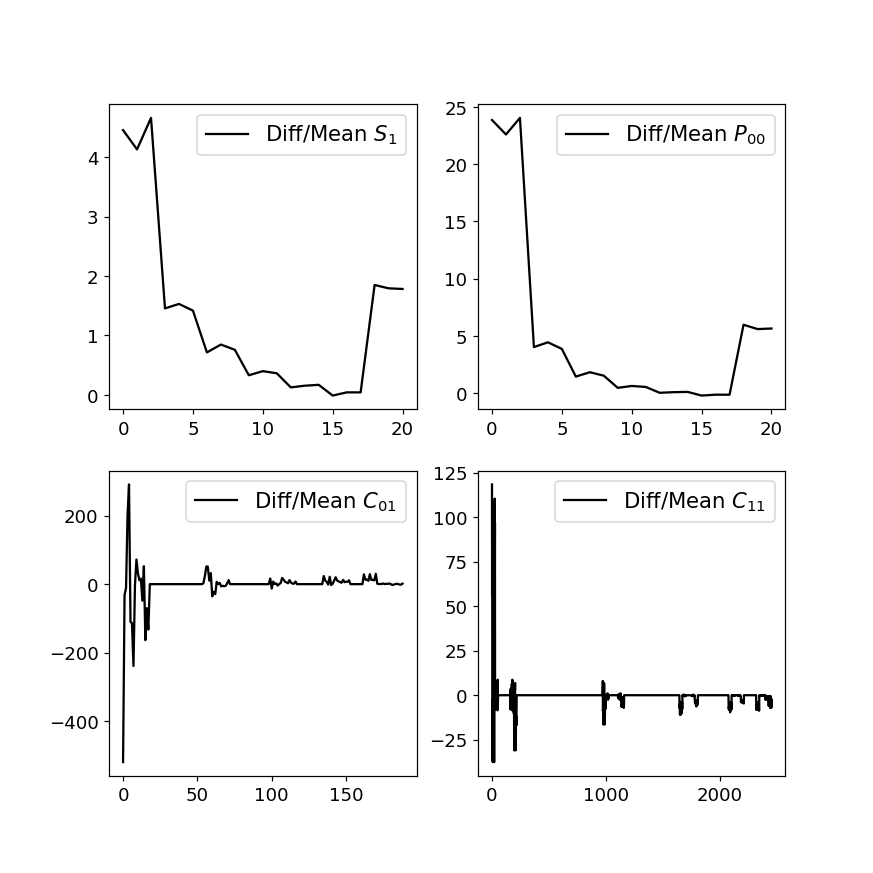

In [27]:
plot.plot_scatcov_coeffs(rel_error(tS1, eS1),
                         rel_error(tP00, eP00),
                         rel_error(tC01, eC01),
                         rel_error(tC11, eC11),
                         name='Diff/Mean', hold=True, color='k')